# **Training Model** 🫁

## **0. Set up**

In [20]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Get in project
%cd /content/drive/MyDrive/Processing_Image
!pwd
!ls -la

/content/drive/MyDrive/Processing_Image
/content/drive/MyDrive/Processing_Image
total 1197093
-rw------- 1 root root       2493 Nov 25 00:52  analyzeData.py
drwx------ 2 root root       4096 Nov 24 17:02  assets
drwx------ 4 root root       4096 Nov 24 17:02  Data
-rw------- 1 root root       3237 Nov 25 00:52  data.py
drwx------ 2 root root       4096 Nov 24 17:02  .git
-rw------- 1 root root       2133 Nov 25 00:52  jetson.py
-rw------- 1 root root        778 Nov 25 00:52  libs.py
-rw------- 1 root root        141 Nov 25 00:52  main.py
drwx------ 2 root root       4096 Nov 25 15:18  Model
drwx------ 2 root root       4096 Nov 24 17:02  myenv
drwx------ 2 root root       4096 Nov 24 17:02 'Pediatric Chest X-ray Pneumonia'
-rw------- 1 root root 1225761664 Nov 14 04:55 'Pediatric Chest X-ray Pneumonia.zip'
drwx------ 2 root root       4096 Nov 24 17:02  __pycache__
-rw------- 1 root root      17233 Nov 14 05:50  README.md
-rw------- 1 root root        138 Nov 14 05:50  testTorch_ver.py

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import os


# PyTorch
import torch

# PyTorch - Neural Networks
import torch.nn as nn
from torch import nn

# PyTorch - Gradient Descent Optimizers
from torch import optim

# PyTorch - Others
from torchvision import datasets, transforms, models
import torchvision.transforms as transform
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Warnings off : Removes unnecessary warnings for a cleaner interface.
import warnings
warnings.filterwarnings("ignore")

# Fix a seed for PyTorch
torch.manual_seed(42);

from torchvision import models

In [ ]:
## ===========================
##   Using GPU
## ===========================

gpu = True

if gpu == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## **1.** Dataset

Before running this line, you should structure the folder according to the following instructions:

- Step 1: Compress the Data folder on your computer into "Data.zip" ("Data" folder structure is already in the README.md file)
- Step 2: Open Google Drive, in "My Drive", create a new folder named "Data"
- Step 3: In the "Data" folder, upload the "Data.zip" folder




## **2.** Prepare Train & Vailid data + Classes Weighting

This part simply calls back the functions that I defined in the 2 files "analyzeData.py" and "Data.py" to perform the evaluation, split the data and calculate the class_weight.

In [ ]:
def prepare_dataset(data_dir, sub_dir='train'):
    """
    Prepare the dataset with transformations and split it into training and validation sets.

    Parameters:
    - data_dir (str): Path to the main data directory.
    - sub_dir (str): The subdirectory where the train data is stored (default: 'train').

    Returns:
    - train_split: Training dataset split.
    - val_split: Validation dataset split.
    """

    full_dir = os.path.join(data_dir, sub_dir)
    if not os.path.exists(full_dir):
        raise FileNotFoundError(f"Directory {full_dir} doesn't exist. Please check the path again!")

    # Define transformations to apply to the data
    data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomGrayscale(),
        transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
        transforms.ToTensor()
    ])

    # Load the dataset using ImageFolder and apply transformations
    dataset = datasets.ImageFolder(full_dir, transform=data_transform)
    print(f"Classes: {dataset.classes}")
    print(f"Total images: {len(dataset)}")

    # Split dataset into training and validation sets
    train_split, val_split = train_test_split(dataset, test_size=0.3, random_state=42)
    print(f"Training set size: {len(train_split)}")
    print(f"Validation set size: {len(val_split)}")

    return train_split, val_split


def load_data(data_dir, sub_dir='train', batch_size=64):
    train_split, val_split = prepare_dataset(data_dir, sub_dir)

    # Create DataLoader for train and validation datasets
    train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=True)

    # Define class index mapping
    class_index = {0: 'NORMAL', 1: 'PNEUMONIA'}

    return train_loader, val_loader, class_index

## ===========================
##   WEIGHTING
## ===========================

def analyze_data(data_dir):
    train_dir = os.path.join(data_dir, 'train')
    normal_train_dir = os.path.join(train_dir, 'NORMAL')
    pneumonia_train_dir = os.path.join(train_dir, 'PNEUMONIA')

    if not os.path.exists(normal_train_dir) or not os.path.exists(pneumonia_train_dir):
        raise FileNotFoundError("One or more specified data directories do not exist. Pls check the paths.")

    # Count samples
    n_samples_nr_train = len(os.listdir(normal_train_dir))
    n_samples_pn_train = len(os.listdir(pneumonia_train_dir))

    # Define result
    class_count = {0: n_samples_nr_train, 1: n_samples_pn_train}
    class_names = {0: 'NORMAL', 1: 'PNEUMONIA'}

    return class_count


def class_weights(class_count):
    """
    Calculate class weights to handle imbalanced datasets.

    Parameters:
    - class_count (dict): A dictionary with class indices as keys and sample counts as values.

    Returns:
    - torch.FloatTensor: A tensor containing class weights.
    """
    samples_0 = class_count[0]
    samples_1 = class_count[1]
    tot_samples = samples_0 + samples_1

    # Calculate weights
    weight_0 = 1 - samples_0 / tot_samples
    weight_1 = 1 - weight_0  # equivalent to 1 - samples_1 / tot_samples

    # Create class weights tensor
    class_weights = [weight_0, weight_1]
    class_weights_tensor = torch.FloatTensor(class_weights)

    # Print weights
    print(f"Class weights: {class_weights_tensor}")
    return class_weights_tensor

In [ ]:
data_dir = 'Data' #Fill in " " your path

# Analyze data distribution
class_count = analyze_data(data_dir)

# Calculate and print class weights
class_weights = class_weights(class_count)

# Load data
train_loader, val_loader, class_index = load_data(data_dir)


Class weights: tensor([0.7422, 0.2578])
Classes: ['NORMAL', 'PNEUMONIA']
Total images: 5232
Training set size: 3662
Validation set size: 1570


## **3.** Model definition

### 3.1 Transfer Learning

In [ ]:
# Base model (transfer learning): DenseNet-161
model = models.densenet161(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### 3.2 Fine-Tuning

In [ ]:
# Important: compatibility problem
# Whatever classifier we put, it will have to have 'model.classifier.in_features' as 'in_features'
model.classifier.in_features

# Freeze the weights of the pre-trained model
for parameter in model.parameters():
    parameter.requires_grad = False

# Build a custom classifier
initial_num_neurons = model.classifier.in_features
num_classes = len(class_index)
classifier = nn.Linear(in_features=initial_num_neurons, out_features=num_classes)
model.classifier = classifier


loss_function = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

## **4** Training

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predictions = torch.max(outputs, dim=1)                   # extract the prediction
    num_correct    = torch.sum(predictions == labels).item()     # count how many correct predictions (.item() to obtain a python-number)
    perc_correct   = torch.tensor(num_correct/len(predictions))

    return perc_correct

def training_step(model, loader, loss_function):

    # Training-mode
    model.train()

    # For every epoch initialize loss and number of correct predictions
    epoch_loss = 0
    epoch_correct = 0

    #--------------------------------- Batch-loop -----------------------------#
    for images, labels in iter(loader):

        # Load images and labels to 'device'
        images, labels = images.to(device), labels.to(device)

        # Initialize the gradient
        optimizer.zero_grad()

        #------------------------------Training -------------------------------#
        with torch.set_grad_enabled(True):

            # Output from the model (from the forward pass)
            output = model(images)

            # Calculate the loss_function for the current batch
            loss = loss_function(output, labels)

            # Perform the backpropagation (backpropagate the error)
            loss.backward()

            # Gradient descent step to update parameters (weights/biases)
            optimizer.step()

            # Extract predictions
            _, predictions = torch.max(output, dim=1)
        #----------------------------------------------------------------------

        # Update loss (+= loss * num_images_in_the_batch)
        # (.item(): returns the value of the tensor as a standard number)
        epoch_loss += loss.item()*images.size(0)

        # Update correct
        epoch_correct += torch.sum(predictions == labels)
    #--------------------------------------------------------------------------#

    # Get the right epoch loss (element_loss / n_element)
    epoch_loss = epoch_loss / len(loader.dataset)

    # Accuracy of the current batch (correct / n_samples)
    accuracy = epoch_correct.double() / len(loader.dataset)

    return epoch_loss, accuracy

def evaluate_model(model, loader, loss_function):

    # Evaluation-mode
    model.eval()

    # For every epoch initialize loss and number of correct predictions
    epoch_loss = 0
    epoch_correct = 0

    #------------------------------ Batch-loop --------------------------------#
    for images, labels in iter(loader):

        # Load images and labels to 'device'
        images, labels = images.to(device), labels.to(device)

        #--------------------------- Evaluation -------------------------------#
        with torch.set_grad_enabled(False):

            # Output from the model (from the forward pass)
            output = model(images)

            # Calculate the loss_function for the current batch
            loss = loss_function(output, labels)

            # Extract predictions
            _, predictions = torch.max(output, dim=1)
        #----------------------------------------------------------------------#

        # Update loss (+= loss * num_images_in_the_batch)
        # (.item(): returns the value of the tensor as a standard number)
        epoch_loss += loss.item()*images.size(0)

        # Update correct
        epoch_correct += torch.sum(predictions == labels)
    #--------------------------------------------------------------------------#

    # Get the right epoch loss (element_loss / n_element)
    epoch_loss = epoch_loss / len(loader.dataset)

    # Accuracy of the current batch (correct / n_samples)
    accuracy = epoch_correct.double() / len(loader.dataset)

    return epoch_loss, accuracy

In [ ]:
# Number of epochs
epochs = 15

# Monitor 'val_loss'
best_val_loss = float('inf')

# Model to device
model.to(device)

# For the records
train_loss_savings = []
train_acc_savings  = []
val_loss_savings   = []
val_acc_savings    = []

# Saving the model
best_model = copy.deepcopy(model.state_dict())

# ======================================
#   TRAINING
# ======================================

for epoch in range(epochs):

    # Training step
    train_loss, train_acc = training_step(model, train_loader, loss_function)
    train_loss_savings.append(train_loss)
    train_acc_savings.append(train_acc.item())

    # Evaluation step
    val_loss, val_acc = evaluate_model(model, val_loader, loss_function)
    val_loss_savings.append(val_loss)
    val_acc_savings.append(val_acc.item())

    # Print results
    print(f'Epoch: {epoch+1:02}/{epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}')

    # If the val_loss improved, save the model
    if val_loss < best_val_loss:
        print(f'Epoch: {epoch+1:02}/{epochs} - val_loss improved from {best_val_loss:.4f} to {val_loss:.4f}, new model saved')
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
    else:
        print(f'Epoch: {epoch+1:02}/{epochs} - val_loss did not improve')

    # Update scheduler (learning rate adapter)
    scheduler.step()

Epoch: 01/15 - train_loss: 0.3898 - train_accuracy: 0.8703 - val_loss: 0.2722 - val_accuracy: 0.9127
Epoch: 01/15 - val_loss improved from inf to 0.2722, new model saved
Epoch: 02/15 - train_loss: 0.2220 - train_accuracy: 0.9230 - val_loss: 0.1807 - val_accuracy: 0.9408
Epoch: 02/15 - val_loss improved from 0.2722 to 0.1807, new model saved
Epoch: 03/15 - train_loss: 0.1836 - train_accuracy: 0.9356 - val_loss: 0.1630 - val_accuracy: 0.9465
Epoch: 03/15 - val_loss improved from 0.1807 to 0.1630, new model saved
Epoch: 04/15 - train_loss: 0.1713 - train_accuracy: 0.9405 - val_loss: 0.1736 - val_accuracy: 0.9522
Epoch: 04/15 - val_loss did not improve
Epoch: 05/15 - train_loss: 0.1517 - train_accuracy: 0.9528 - val_loss: 0.1532 - val_accuracy: 0.9561
Epoch: 05/15 - val_loss improved from 0.1630 to 0.1532, new model saved
Epoch: 06/15 - train_loss: 0.1502 - train_accuracy: 0.9476 - val_loss: 0.1473 - val_accuracy: 0.9510
Epoch: 06/15 - val_loss improved from 0.1532 to 0.1473, new model sav

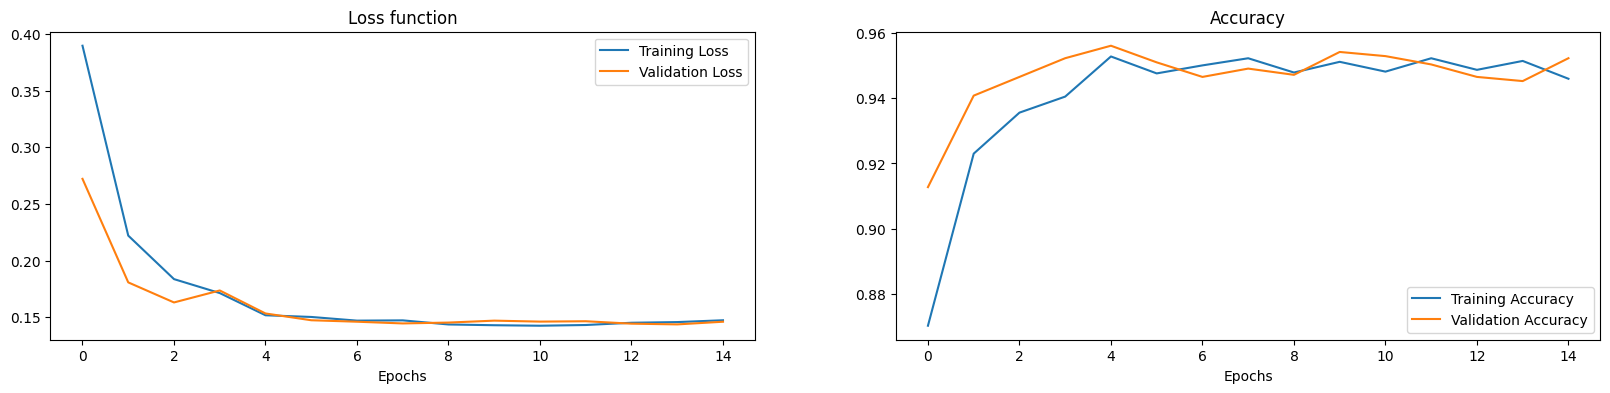

In [ ]:
# ======================================
#   TRENDS
# ======================================

plt.figure(figsize=(20,4));

# Loss function
plt.subplot(1,2,1)
plt.plot(train_loss_savings, label='Training Loss');
plt.plot(val_loss_savings, label='Validation Loss');
plt.title('Loss function');
plt.xlabel('Epochs');
plt.legend();

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_acc_savings, label='Training Accuracy');
plt.plot(val_acc_savings, label='Validation Accuracy');
plt.title('Accuracy');
plt.xlabel('Epochs');
plt.legend();

In [ ]:
# ======================================
#   SAVE THE MODEL
# ======================================

# Path for saving the best model
path_best_model = '/content/drive/MyDrive/Processing_Image/Model/'

# Save the model
torch.save(model.state_dict(), path_best_model + 'best-model-weighted.pt')

## **5. Predict**

In [ ]:
# Load the best version of the model
model.load_state_dict(torch.load(path_best_model + 'best-model-weighted.pt'))

<All keys matched successfully>

In [ ]:
# Import the test data
test_transform = transforms.Compose([
                     transforms.Resize((256, 256)),
                     transforms.CenterCrop(224),
                     transforms.ToTensor()])

test_data = datasets.ImageFolder('Data/test', transform = test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)

In [ ]:
def get_probs_and_preds(model, loader):

    model.eval()

    images_savings = []
    labels_savings = []
    probs_savings  = []
    preds_savings  = []

    #---------------------------------------------------------- Batch-loop ---------#
    for images, labels in iter(loader):                                             #
        images, labels = images.to(device), labels.to(device)                       #
        #------------------------------------------------------ Evaluation ----#    #
        with torch.set_grad_enabled(False):                                    #    #
            output = model(images)                                             #    #
            output = F.softmax(output)                                         #    #
            probabilities, predictions = torch.max(output, dim=1)              #    #
        #----------------------------------------------------------------------#    #
        images_savings.append(images.cpu())                                         #
        labels_savings += labels.tolist()                                           #
        probs_savings  += probabilities.tolist()                                    #
        preds_savings  += predictions.tolist()                                      #
    #-------------------------------------------------------------------------------#

    # Accuracy
    correct_elements = 0
    for i in range(len(labels_savings)):
        if labels_savings[i] == preds_savings[i]:
            correct_elements += 1
    accuracy = correct_elements/len(labels_savings)

    return images_savings, labels_savings, probs_savings, preds_savings, accuracy

In [ ]:
# Evaluate the model on test data
images, labels, probs, preds, accuracy = get_probs_and_preds(model, test_loader)

# Print results
print(f'Accuracy on test: {accuracy:.4f}')

Accuracy on test: 0.9022


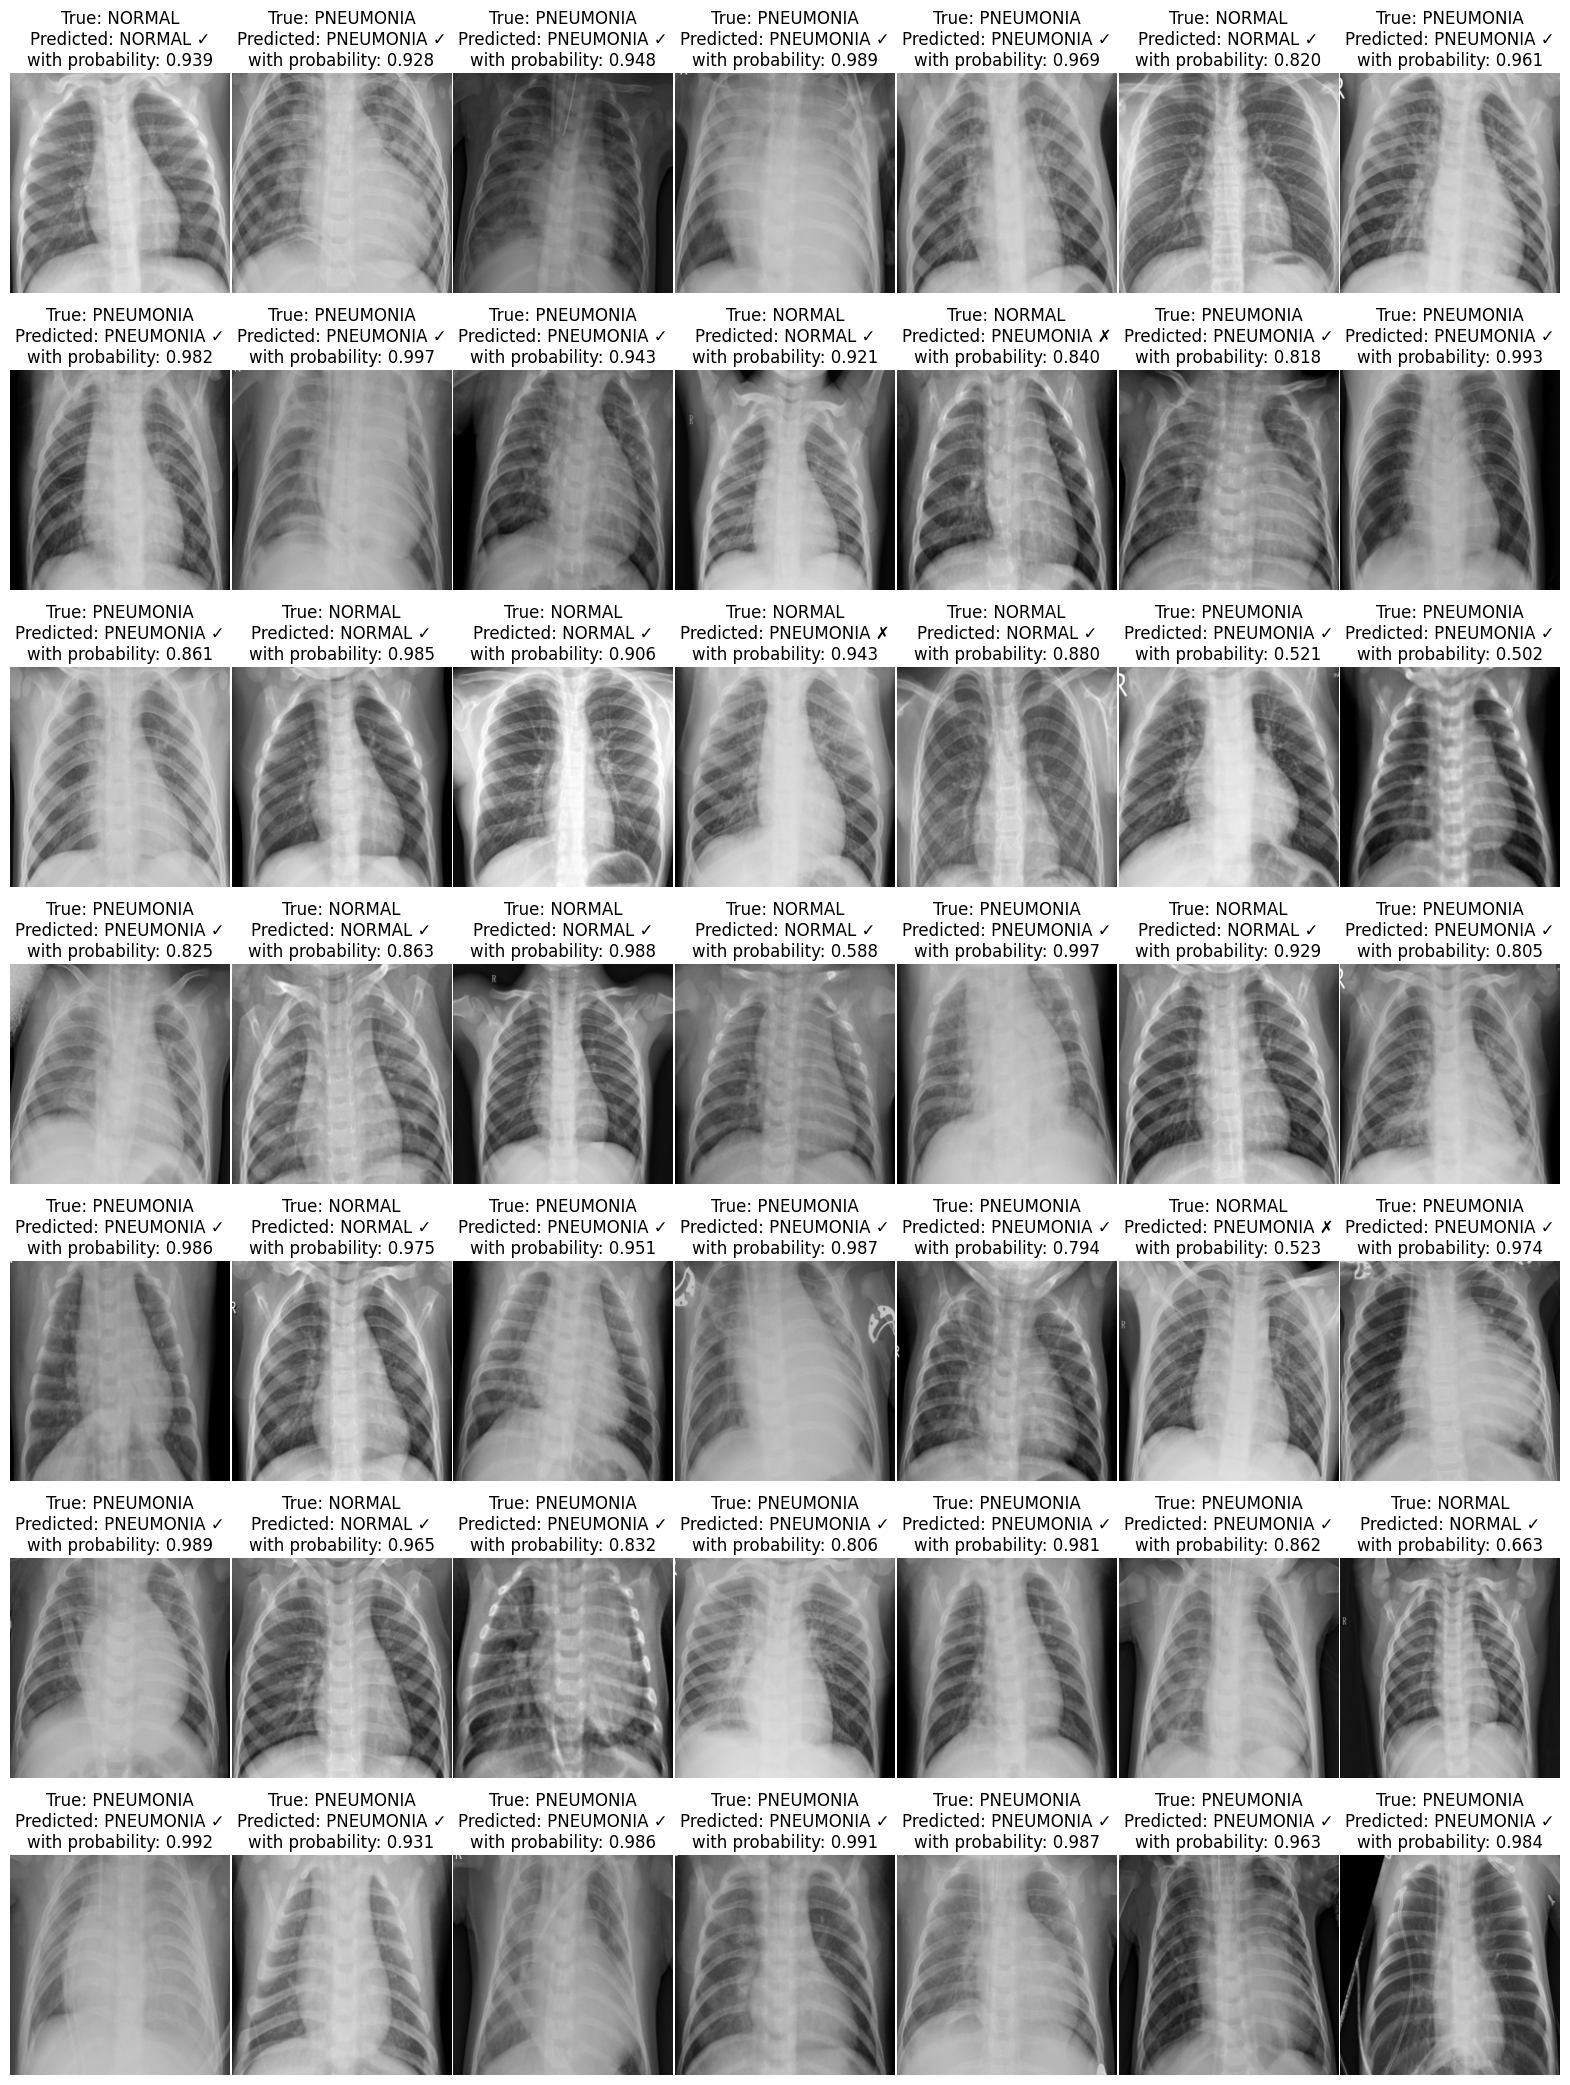

In [ ]:
plt.figure(figsize=(20, 26))
n_rows = 7
n_cols = 7

# Display images
for i in range(n_rows*n_cols):
  text_true = 'True: ' + class_index[labels[i]]
  text_pred = '\nPredicted: ' + class_index[preds[i]]
  text_prob = '\nwith probability: ' + str(probs[i])[:5]

  if labels[i] == preds[i]:
      text_correct = ' ✓'
  else:
      text_correct = ' ✗'

  # Plot the image
  plt.subplot(n_rows, n_cols, i+1)
  plt.imshow(np.transpose(images[0][i].numpy(), (1, 2, 0)))
  plt.title(text_true + text_pred + text_correct + text_prob)
  plt.axis('off')

plt.subplots_adjust(wspace=.01, hspace=.35)